In [94]:
import pickle
import re
import numpy as np

basis_file = '/home/anton/Documents/Tulane/Research/PNC_Good/AngleBasisLong5.pkl'
demodir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC/'

basis = pickle.load(open(basis_file, 'rb'))

thetas = []
jitter = []
age = []
fc = []
sex = []
race = []

demo = pickle.load(open(f'{demodir}/demographics.pkl', 'rb'))

for subtask in basis:
    m = re.search('([^-]+)-(.*)', subtask)
#     m = re.search('([^-]+)', subtask)
    sub = m.group(1)
    task = m.group(2)
    a = demo['age_at_cnb'][sub]
    age.append(a)
    s = demo['Sex'][sub] == 'M'
    r = demo['Race'][sub] == 'AA'
    sex.append(s)
    race.append(r)
    thetas.append(basis[subtask]['thetas'])
    jitter.append(basis[subtask]['jitter'])
    p = np.load(f'{demodir}/fc/{sub}_task-{task}_fc.npy')
    fc.append(p)
    
thetas = np.stack(thetas)
jitter = np.stack(jitter)
age = np.array(age)
fc = np.stack(fc)
sex = np.array(sex).astype('int')
race = np.array(race).astype('int')

print([a.shape for a in [thetas, jitter, age, sex, race, fc]])
print(np.mean(age))

[(3849, 5, 264), (3849, 5, 264), (3849,), (3849,), (3849,), (3849, 34716)]
14.398285268901013


In [70]:
# BSNIP

import pickle
import re
import numpy as np

basis_file = '/home/anton/Documents/Tulane/Research/BSNIP/AngleBasisLong5.pkl'
demodir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/BSNIP/'

basis = pickle.load(open(basis_file, 'rb'))

thetas = []
jitter = []
age = []
sex = []
race = []
sz = []
fc = []

demo = pickle.load(open(f'{demodir}/demographics.pkl', 'rb'))

for subtask in basis:
#     m = re.search('([^-]+)-(.*)', subtask)
    m = re.search('([^-]+)', subtask)
    sub = m.group(1)
#     task = m.group(2)
    a = demo['Age_cal'][sub]
    s = demo['sex'][sub] == 's1.0'
    r = demo['Race'][sub] == 'AA'
    z = demo['DXGROUP_2'][sub] == 'SZP'
    if demo['DXGROUP_2'][sub] not in ['SZP', 'NC']:#, 'SADR', 'BPR', 'SZR']:
        continue
    age.append(a)
    sz.append(z)
    sex.append(s)
    race.append(r)
    thetas.append(basis[subtask]['thetas'])
    jitter.append(basis[subtask]['jitter'])
    p = np.load(f'{demodir}/fc/{sub}_task-unk_fc.npy')
    fc.append(p)
    
thetas = np.stack(thetas)
jitter = np.stack(jitter)
age = np.array(age).astype('int')
sex = np.array(sex).astype('int')
race = np.array(race).astype('int')
sz = np.array(sz).astype('int')
fc = np.stack(fc)

print([a.shape for a in [thetas, jitter, sex, race, sz, age, fc]])
print(np.mean(1-sex))
print(np.mean(1-race))
print(np.mean(1-sz))
print(np.mean(age))

[(441, 5, 264), (441, 5, 264), (441,), (441,), (441,), (441,), (441, 34716)]
0.4580498866213152
0.6439909297052154
0.5487528344671202
36.54875283446712


In [95]:
def rmse(yhat, y):
    if isinstance(yhat, np.ndarray) or isinstance(yhat, int):
        f = np.mean
    else:
        f = torch.mean
    return f((y-yhat)**2)**0.5

def tops(thetas, jitter):
    t0 = np.expand_dims(thetas, 2)
    t1 = np.expand_dims(thetas, 3)
    j0 = np.expand_dims(jitter, 2)
    j1 = np.expand_dims(jitter, 3)
    ps = np.cos(t0-t1)*(j0*j1)
    a,b = np.triu_indices(264, 1)
    ps = ps[:,:,a,b]
    return ps
    
ps = tops(thetas, jitter)
aps = np.mean(ps, axis=1)
res = fc - aps

print(ps.shape)
print(aps.shape)
print(res.shape)

(3849, 5, 34716)
(3849, 34716)
(3849, 34716)


In [162]:
import torch
import torch.nn.functional as F

def fromnp(x):
    return torch.from_numpy(x).float().cuda()

def tonp(x):
    return x.detach().cpu().numpy()

sel = np.arange(fc.shape[0]) 
sel = (sex == 1)*(race == 0)
sel = (age > 18)*(race == 1)

fct = fromnp(res[sel])
# dfc = torch.cdist(fct, fct)
fct = F.normalize(fct)
dfc = fct@fct.T
dfc = tonp(dfc)
print(dfc.shape)

idcs = np.argsort(dfc)
print(idcs[:100,-2])

(193, 193)
[  1   2   1   5   5   4   7   8   7  11  11  10  13  14  13  16  17  16
  19  20  19  22  23  22  26  26  25  28  29  28  32  32  31  34  33  37
  37  36  39  40  39  43  43  41  46  46  45  49  49  48  51  52  51  55
  55  54  58  58  57  17  61  62  61  64  65  64  67  68  67  71  71  70
  73  74  73  77  77  76  79  80  79  82  81  84  85  84  87  88  87  91
  91  90  93  94  93  96  97  96 100 100]


In [163]:
import torch 
import torch.nn as nn

class Dists(nn.Module):
    def __init__(self, n):
        super(Dists, self).__init__()
        self.xy = nn.Parameter(torch.randn(n,2).float().cuda())
        
    def forward(self):
        return torch.cdist(self.xy, self.xy)

# tgt = 1e-1*np.ones(dfc.shape)
# for i in range(dfc.shape[0]):
#     tgt[i,idcs[i,-2000:]] = dfc[i, idcs[i,-2000:]]
    
# tgt = 1/fromnp(tgt)
tgt = 1/fromnp(dfc)
# tgt = torch.eye(dfc.shape[0]).float().cuda()
dists = Dists(dfc.shape[0])

nepochs = 1000
pperiod = 50

optim = torch.optim.Adam(dists.parameters(), lr=1e0, weight_decay=0)

for e in range(nepochs):
    optim.zero_grad()
    d = dists()
    loss = rmse(d, tgt)
    loss.backward()
    optim.step()
    if e % pperiod == 0 or e == nepochs-1:
        print(f'{e} {float(loss)}')
        
print('Complete')

0 10.90683650970459
50 4.760171413421631
100 4.543347358703613
150 4.425577163696289
200 4.382279872894287
250 4.36593770980835
300 4.3552327156066895
350 4.341176986694336
400 4.318910598754883
450 4.317915916442871
500 4.316577911376953
550 4.3159918785095215
600 4.315565586090088
650 4.315562725067139
700 4.315563201904297
750 4.315562725067139
800 4.315563201904297
850 4.315562725067139
900 4.315562725067139
950 4.315562725067139
999 4.315563201904297
Complete


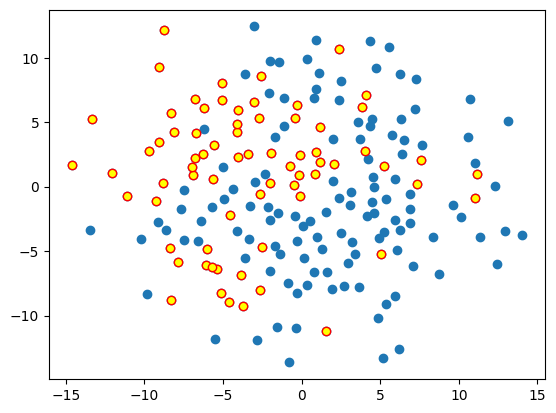

In [164]:
import matplotlib.pyplot as plt

dd = tonp(dists.xy)
# sel2 = (age[sel] > 18)
sel2 = sex[sel] == 1
# sel2 = (sz[sel] == 1)#*(race == 0)*(sex == 1)#*(age < 35) #(age >= 12)*(age <= 18)
# sel = np.arange(dd.shape[0])

plt.scatter(dd[:,0], dd[:,1])
plt.scatter(dd[sel2,0], dd[sel2,1], color='yellow', edgecolor='red')
plt.show()

In [ ]:
import umap

reducer = umap.UMAP()
emb = reducer.fit_transform(aps)

print(emb.shape)

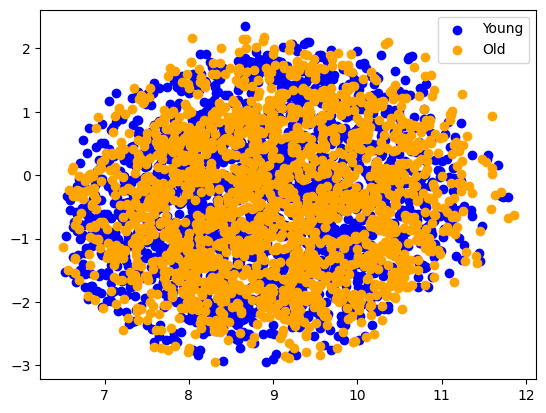

In [13]:
import matplotlib.pyplot as plt

color = iter(['blue', 'orange', 'green'])

# other = np.all([y != 0, y != 6], axis=0)
# plt.scatter(emb[other, 0], emb[other, 1], c=next(color), alpha=0.1, label='Other')

for c,lab in zip([race == 0, race == 1], ['Young', 'Old']):
    plt.scatter(emb[c,0], emb[c,1], c=next(color), label=lab)    
    
plt.legend()
plt.show()

In [7]:
emb[age < 12].shape

(914, 2)